In [1]:
from utils.data_loader import *
from utils.null_handler import *
from utils.model_tuning_utils import *
from sys import getsizeof
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SEED=10

In [2]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment
    # clear_output()

### Loading ACSEmployment data

In [3]:
config = {
    'state': ["CA"],
    'year': '2016',
    'task': ACSEmployment
}

In [4]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [5]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 45 mb
Optimized: 23 mb


#### Checking if there are nulls in the dataset

In [6]:
X_data.isnull().sum()

AGEP             0
SCHL         11466
MAR              0
RELP             0
DIS              0
ESP         300716
CIT              0
MIG           3702
MIL          74731
ANC              0
NATIVITY         0
DEAR             0
DEYE             0
DREM         19605
SEX              0
RAC1P            0
dtype: int64

### Preprocessing: Handling nulls

In [7]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']

In [8]:
handle_nulls = {
'special': ['SCHL','MIG', 'MIL', 'DREM', 'ESP'],
   # 'drop-rows': ['ESP'],
   # 'drop-column': ['ESP']
}

In [9]:
#Checking dataset shape before handling nulls
X_data.shape, X_data.columns

((376035, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

In [10]:
for how_to in handle_nulls.keys():
    X_data = handle_df_nulls(X_data, how_to, handle_nulls[how_to])

In [11]:
#Checking dataset shape after handling nulls
X_data.shape, X_data.columns

((376035, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

#### Rechecking if there are nulls -- if the null_handler has run correctly, there should not be

In [12]:
X_data.isnull().sum()

AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

### Other data pre-processing (making dummies, scaling etc)

In [13]:
X_data.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
      dtype='object')

In [14]:
def make_feature_df(data, categorical_columns, numerical_columns):
    feature_df = pd.get_dummies(X_data[categorical_columns], columns=categorical_columns)
    for col in numerical_columns:
        feature_df[col] = data[col]
    return feature_df

In [15]:
categorical_col = ['MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
numerical_col = ['AGEP', 'SCHL']

In [16]:
X_features = make_feature_df(X_data, categorical_col, numerical_col)

In [17]:
X_features.shape, X_data.shape

((376035, 74), (376035, 16))

### Model selection after hyperparameter tuning

In [18]:
X_train_, X_test, y_train_, y_test = train_test_split(X_features, y_data, test_size=0.2, random_state=SEED)
X_train_.shape, X_test.shape

((300828, 74), (75207, 74))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25, random_state=SEED)
X_train.shape, X_val.shape

((225621, 74), (75207, 74))

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
n_folds = 3
samples_per_fold = len(y_val)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [22]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [10],
            "n_estimators": [30],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [10],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [200],
            'max_depth': [5],
            'objective':  ['binary:logistic'],
        }
    }
]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    retu

Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

           0      0.888     0.766     0.823     41765
           1      0.751     0.880     0.810     33442

    accuracy                          0.817     75207
   macro avg      0.820     0.823     0.817     75207
weighted avg      0.827     0.817     0.817     75207



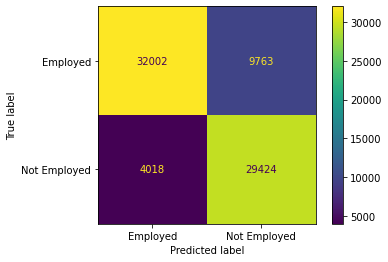

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 156, in fit
    X, y = self._validate_data(X, y,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Library/Fram

Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.877     0.771     0.821     41765
           1      0.752     0.865     0.805     33442

    accuracy                          0.813     75207
   macro avg      0.814     0.818     0.813     75207
weighted avg      0.821     0.813     0.814     75207



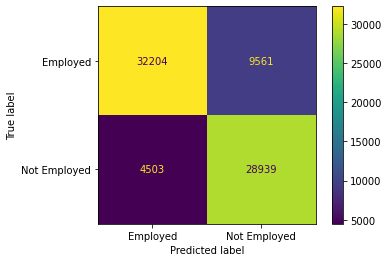

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3; 1/1] START learning_rate=0.1, max_depth=5, n_estimators=200, objective=binary:logistic
[11:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1350: Empty dataset at worker: 0
[11:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1350: Empty dataset at worker: 0
[11:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1350: Empty dataset at worker: 0
[11:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1350: Empty dataset at worker: 0
[11:54:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1350: Empty dataset at worker: 0
[11:54:32] WARNING: /Users/runner/work/xgboos

Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.880     0.781     0.828     41765
           1      0.760     0.867     0.810     33442

    accuracy                          0.819     75207
   macro avg      0.820     0.824     0.819     75207
weighted avg      0.827     0.819     0.820     75207



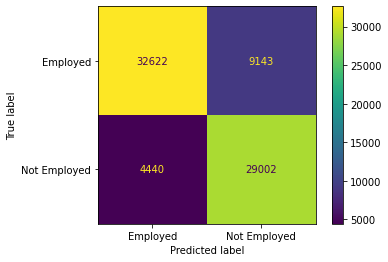

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.816544,0.816759,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],DecisionTreeClassifier,0.812643,0.812996,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [LA],XGBClassifier,0.818972,0.819392,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


[CV 3/3; 1/1] START bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30
[CV 3/3; 1/1] END bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30; Accuracy_Score: (test=nan) F1_Score: (test=nan) total time=   0.1s
[CV 2/3; 1/1] START bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30
[CV 2/3; 1/1] END bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30; Accuracy_Score: (test=0.815) F1_Score: (test=0.815) total time=   5.7s
[CV 3/3; 1/1] START criterion=gini, max_depth=10, max_features=0.6..............
[CV 3/3; 1/1] END criterion=gini, max_depth=10, max_features=0.6; Accuracy_Score: (test=nan) F1_Score: (test=nan) total time=   0.0s
[CV 1/3; 1/1] START bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30
[CV 1/3; 1/1] END bootstrap=True, max_depth=10, max_features=0.6, n_estimators=30; Accuracy_Score: (test=0.819) F1_Score: (test=0.819) total time=  12.2s
[CV 1/3; 1/1] START criterion=gini, max_depth=10, max_features=0.6..........

In [23]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_val, y_val, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [27]:
ML_results_df['Model_Best_Params'][2]

{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

In [29]:
best_model = XGBClassifier(learning_rate=0.1, max_depth=5,n_estimators=200,objective='binary:logistic')
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [31]:
best_model.score(X_train, y_train)

0.8219935201067277

In [32]:
best_model.score(X_test, y_test)

0.8186472003935804

TODO: Write null-imputer, scaler, test_ML_models into one sklearn-pipeline